In [1]:
import numpy as np
import helpful_functions as hf
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# load saved encoder and decoder
encoder = keras.models.load_model("saved_model/encoder_5x5x16_2")
decoder = keras.models.load_model("saved_model/decoder_5x5x16_2")

# build autoencoder with trained model
autoencoder_input1 = keras.Input(shape=(32, 32, 1), name="input_img1")
autoencoder_input2 = keras.Input(shape=(32, 32, 1), name="input_img2")
encoded_img1 = encoder(autoencoder_input1)
encoded_img2 = encoder(autoencoder_input2)
encoded_img3 = layers.subtract((encoded_img1, encoded_img2))
decoded_img1 = decoder(encoded_img1)
decoded_img2 = decoder(encoded_img2)
decoded_img3 = decoder(encoded_img3)
autoencoder = keras.Model(inputs=[autoencoder_input1,autoencoder_input2],
                          outputs=[decoded_img1,decoded_img2,decoded_img3], name="autoencoder")
autoencoder.summary()

Metal device set to: Apple M2


2023-04-10 11:16:33.735898: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-10 11:16:33.736096: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "autoencoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img1 (InputLayer)        [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 input_img2 (InputLayer)        [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 encoder (Functional)           (None, 5, 5, 16)     15168       ['input_img1[0][0]',             
                                                                  'input_img2[0][0]']             
                                                                                                  
 subtract (Subtract)            (None, 5, 5, 16)     0           ['encoder[0][0]',      

In [3]:
# load data_set
data_set = hf.load_dataset_npz('data_set/10000samples_3_8_ratio03_sub.npz')
#data_set = hf.load_dataset_npz('data_set/10000samples_3_8_sub_noise.npz')
#data_set = hf.load_dataset_npz('data_set/10000samples_3_8_ratio05.npz')
data_set = data_set.astype('float32')
x_train = data_set[:8000, :1]
y_train = data_set[:8000,2]
x_test = data_set[8000:, :1]
y_test = data_set[8000:, 2]

x_train_ell = data_set[:8000, 1]
y_train_rec = data_set[:8000, 2]
x_train_all = data_set[:8000, 0]

x_test_ell = data_set[8000:, 1]
y_test_rec = data_set[8000:, 2]
x_test_all = data_set[8000:, 0]

In [4]:
# make predications
predictions = autoencoder.predict([x_test_all,x_test_ell])
np.shape(predictions)

2023-04-10 11:16:39.763230: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-10 11:16:39.894248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


63/63 [==============================] - 1s 12ms/step


(3, 2000, 32, 32, 1)

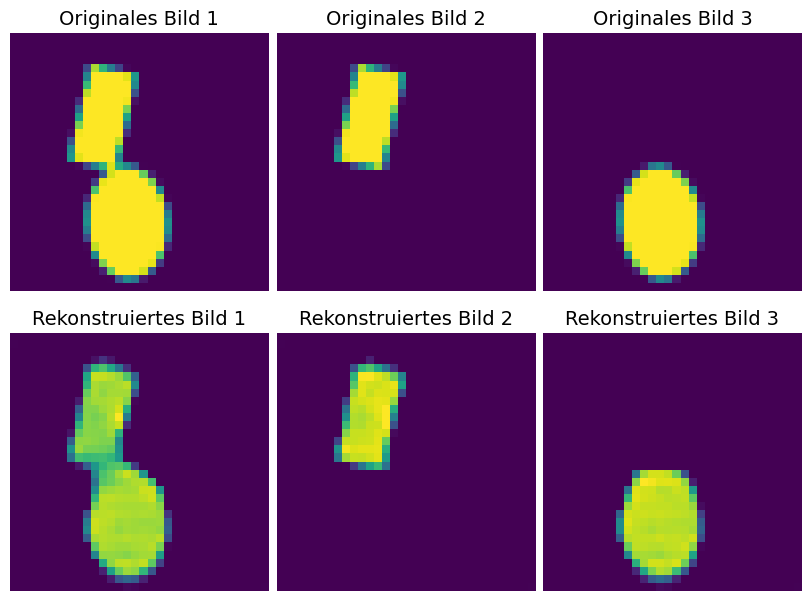

In [21]:
# Visualization
num = 35
fig, ax = plt.subplots(2, 3, figsize=(8, 6), constrained_layout=True)
#fig1.suptitle('Original image', y=0.75)
ax[0][0].imshow(x_test_all[num - 1], origin='lower')
ax[0][0].set_title(f'Originales Bild 1', fontsize=14)
ax[0][0].axis('off')
ax[0][1].imshow(x_test_ell[num - 1], origin='lower')
ax[0][1].set_title(f'Originales Bild 2', fontsize=14)
ax[0][1].axis('off')
ax[0][2].imshow(y_test_rec[num - 1], origin='lower')
ax[0][2].set_title(f'Originales Bild 3', fontsize=14)
ax[0][2].axis('off')
ax[1][0].imshow(predictions[0][num-1], origin='lower')
ax[1][0].set_title(f'Rekonstruiertes Bild 1', fontsize=14)
ax[1][0].axis('off')
ax[1][1].imshow(predictions[1][num-1], origin='lower')
ax[1][1].set_title(f'Rekonstruiertes Bild 2', fontsize=14)
ax[1][1].axis('off')
ax[1][2].imshow(predictions[2][num-1], origin='lower')
ax[1][2].set_title(f'Rekonstruiertes Bild 3', fontsize=14)
ax[1][2].axis('off')
plt.savefig("Ausarbeitung/graphic/sub_pretrained.svg")


In [10]:
mse = tf.keras.losses.MeanSquaredError()
#mse(y_test[:,3], predictions[3]).numpy()
print(f"mse is: {mse(y_test_rec, predictions).numpy()}")
ssim = tf.image.ssim(y_test_rec, predictions,max_val=1.0)
ssim_mean = np.mean(ssim)
#print(f"ssim is for sample {40}: {ssim[40].numpy()}")
print(f"mean of ssim is: {ssim_mean}")

mse is: 0.06800837069749832
mean of ssim is: 0.6280145049095154
